cuda:0


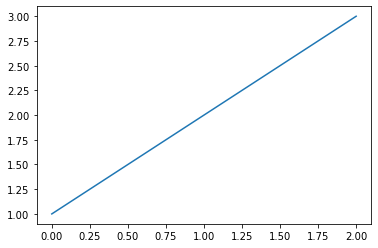

In [3]:
import importlib
from matplotlib import pyplot as plt
plt.plot([1,2,3])
from IPython.display import clear_output
import matplotlib
import numpy as np
import pandas as pd
import pdb
import time
from collections import deque
import torch
import cv2
from Environment.Env import RealExpEnv
from RL.sac import sac_agent, ReplayMemory
from Environment.data_visualization import plot_graph, show_reset, show_done, show_step
from Environment.episode_memory import Episode_Memory
from Environment.get_atom_coordinate import atom_detection, blob_detection, get_atom_coordinate_nm
from skimage import morphology, measure
from Environment.createc_control import Createc_Controller
import glob
from collections import deque
matplotlib.rcParams['image.cmap'] = 'gray'
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

succeed to connect


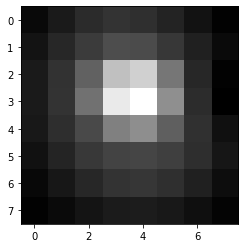

In [5]:
createc_controller = Createc_Controller(None, None, None, None)
img_forward = np.array(createc_controller.stm.scandata(1,4))

top_left, w, h = (54,2), 8, 8
template = img_forward[top_left[1]:top_left[1]+h, top_left[0]:top_left[0]+w]
template_path = 'template.png'
cv2.imwrite(template_path, template)
plt.imshow(template)

In [6]:
step_nm = 0.4
max_mvolt = 15 #min_mvolt = 0.5*max_mvolt
max_pcurrent_to_mvolt_ratio = 6E3 # min = 0.5*max
goal_nm  = 2
current_jump  = 5
im_size_nm = 13.08
DactoA = float(createc_controller.stm.getparam('Dacto[A]xy'))
Gain = float(createc_controller.stm.getparam("GainX"))
print('gain:', Gain)
offset_x = -float(createc_controller.stm.getparam('OffsetX'))*DactoA*Gain/10
offset_y = -float(createc_controller.stm.getparam('OffsetY'))*DactoA*Gain/10
print(offset_x, offset_y)
offset_nm = np.array([-60.777,191.507])
pixel = 64
manip_limit_nm = np.array([-66, -58, 196, 204]) #[left, right, up, down]
template_max_y = 14
template_min_x = None
scan_mV = 1000
max_len = 5
env = RealExpEnv(step_nm, max_mvolt, max_pcurrent_to_mvolt_ratio, goal_nm, 
                 template, current_jump, im_size_nm, offset_nm, manip_limit_nm, pixel, 
                 template_max_y, template_min_x, scan_mV, max_len)
episode_memory = Episode_Memory()

gain: 10.0
-61.143851000000005 192.66283099999998
succeed to connect


In [13]:
def dummy_action(atom, destination, mvolt = 10, pcurrent=60E3):
    destination_atom = destination - atom
    action = np.zeros(6)
    if np.any(np.abs(destination_atom)>env.goal_nm):
        if np.abs(destination_atom[0])>=np.abs(destination_atom[1]):
            action[2] = np.sign(destination_atom[0])
            action[3] = action[2]*destination_atom[1]/destination_atom[0]
        else:
            action[3] = np.sign(destination_atom[1])
            action[2] = action[3]*destination_atom[0]/destination_atom[1]
    else:
        action[2:4] = destination_atom/env.goal_nm
    action[:2] = np.random.random(2)-0.5
    action[4] = mvolt/env.max_mvolt
    action[5] = pcurrent/(mvolt*env.max_pcurrent_to_mvolt_ratio)
    return action
            

In [16]:
scores_array = []
avg_scores_array = []

def sac_train(max_steps, num_episodes = 50, episode_start = 0):
    global added_episode
    for i_episode in range(episode_start,episode_start+num_episodes):
        print('Episode:', i_episode)
        episode_reward = 0
        episode_steps = 0
        done = False
        state, info = env.reset()
        show_reset(env.img_info['img_forward'], env.img_info['offset_nm'], env.img_info['len_nm'], 
                   env.atom_start_absolute_nm, env.destination_absolute_nm, env.template_nm, env.template_wh)
        print('old value:',env.old_value)
        #print(env.atom_absolute_nm)
        episode_memory.update_memory_reset(env.img_info, i_episode, info)
        for step in range(max_steps):
            print('step:', step)
            #action = agent.select_action(state)
            action = dummy_action(env.atom_relative_nm, env.destination_relative_nm)
            atom_absolute_nm = env.atom_absolute_nm
            next_state, reward, done, info = env.step(action)
            print(reward)
            #print(action, done, reward)
            episode_steps+=1
            episode_reward+=reward
            mask = float(not done)
            
            episode_memory.update_memory_step(state, action, next_state, reward, done, info)
            state=next_state
            show_step(env.img_info['img_forward'], env.img_info['offset_nm'], env.img_info['len_nm'], 
                      info['start_nm']+atom_absolute_nm, info['end_nm']+atom_absolute_nm,
                      env.atom_absolute_nm, env.atom_start_absolute_nm, env.destination_absolute_nm, 
                      env.template_nm, env.template_wh, action[4]*env.max_mvolt, 
                      action[5]*env.max_pcurrent_to_mvolt_ratio*action[4]*env.max_mvolt)
            if done:
                episode_memory.update_memory_done(env.img_info, env.atom_absolute_nm, env.atom_relative_nm)
                episode_memory.save_memory('benchmark')
                new_destination_absolute_nm = None
                atom_to_start = env.atom_relative_nm - env.atom_start_relative_nm
                print('atom moved by:', np.linalg.norm(atom_to_start))
                print('Episode reward:', episode_reward)
                show_done(env.img_info['img_forward'], env.img_info['offset_nm'], env.img_info['len_nm'], env.atom_absolute_nm, env.atom_start_absolute_nm, env.destination_absolute_nm, env.template_nm, env.template_wh, reward, new_destination_absolute_nm)
                
                break
        
        scores_array.append(episode_reward)
        if len(scores_array)>100:
            avg_scores_array.append(np.mean(scores_array[-100:]))
        else:
            avg_scores_array.append(np.mean(scores_array))
            
        
        if (i_episode+1)%2==0:
            plot_graph(scores_array,avg_scores_array)

In [17]:
env.atom_absolute_nm = None

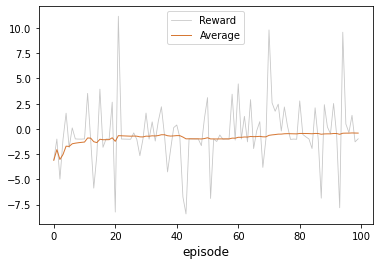

In [18]:
sac_train(max_steps=max_len, episode_start = 0,num_episodes = 100)

1.1941248353849678


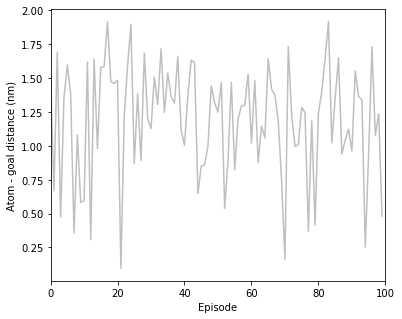

In [20]:
atom_destination_distance = []
for i, np_name in enumerate(glob.glob('benchmark/*.npy')):
    try:
        data = np.load(np_name,allow_pickle=True).item()
        destination_relative = data['episode_start_info']['info']['goal_relative_nm']
        atom_relative = data['episode_end_info']['atom_relative_nm']
        atom_destination_distance.append(np.linalg.norm(atom_relative - destination_relative))
    except:
        pass
n = 100
plt.subplots(figsize=(6,5))
avg_atom_destination_distance = np.convolve(atom_destination_distance, np.ones(n), mode='valid')/n
plt.plot(atom_destination_distance, color='gray', alpha=0.5)

plt.plot(np.arange(n,len(atom_destination_distance)+1),avg_atom_destination_distance, linewidth=3, color='#B85C38')
plt.xlim([0,len(atom_destination_distance)])
#plt.ylim([0,np.max(avg_atom_destination_distance)+0.1])
plt.xlabel('Episode')
plt.ylabel('Atom - goal distance (nm)')
print(avg_atom_destination_distance[-1])

In [10]:
def save_buffer(buffer):
    state, action, reward, next_state, done = map(np.stack,zip(*memory.buffer))
    np.save('state.npy',state)
    np.save('action.npy',action)
    np.save('reward.npy',reward)
    np.save('next_state.npy', next_state)
    np.save('done.npy', done)
save_buffer(memory.buffer)